In [ ]:
!pip install scikeras
!pip install keras==2.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.14.0 which is incompatible.


In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn .preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [ ]:
from google.colab import drive
drive.mount('content.drive')

df_ana=pd.read_csv("/content/content.drive/MyDrive/Colab Notebooks/ANAホールディングス.csv", encoding="shift-jis")
print('Number of rows and columns:', df_ana.shape)
df_ana.head(5)

Mounted at content.drive
Number of rows and columns: (10219, 7)


,日付,始値,高値,安値,終値,出来高,調整後終値
0,2023/9/29,3179.0,3185.0,3115.0,3133.0,3613900,3133.0
1,2023/9/28,3244.0,3254.0,3130.0,3165.0,6311500,3165.0
2,2023/9/27,3250.0,3286.0,3239.0,3274.0,5288600,3274.0
3,2023/9/26,3290.0,3291.0,3263.0,3272.0,2245300,3272.0
4,2023/9/25,3269.0,3303.0,3268.0,3300.0,2397500,3300.0


In [ ]:
# ラベル名変更
df_ana = df_ana.rename(columns={'日付': 'Date', '始値': 'Open', '高値': 'High', '安値': 'Low', '終値': 'Close', '出来高': 'Turnover', '調整後終値': 'AdClose'})

df_ana["Date"] = pd.to_datetime(df_ana["Date"])
from datetime import datetime

# 並べ替え、番号振り直し
df_ana = df_ana.sort_values('Date', ascending=True)
df_ana = df_ana[(df_ana["Date"] > datetime(2010,12,31)) & (df_ana["Date"] < datetime(2023, 1, 4))]

# df_rakuten['Date'] = df_rakuten['Date'].astype(str)
# 並べ替え、番号振り直し
df_ana = df_ana.sort_values('Date', ascending=True)
df_ana = df_ana.reset_index(drop=True)

df_ana

,Date,Open,High,Low,Close,Turnover,AdClose
0,2011-01-04,307.0,307.0,305.0,307.0,4807000,3070.0
1,2011-01-05,307.0,309.0,304.0,305.0,6033000,3050.0
2,2011-01-06,306.0,307.0,303.0,305.0,5681000,3050.0
3,2011-01-07,306.0,307.0,304.0,306.0,6120000,3060.0
4,2011-01-11,305.0,306.0,304.0,305.0,3191000,3050.0
...,...,...,...,...,...,...,...
2930,2022-12-26,2809.0,2833.5,2804.0,2821.5,1229200,2821.5
2931,2022-12-27,2840.0,2904.5,2837.0,2862.5,3098300,2862.5
2932,2022-12-28,2853.0,2872.0,2819.0,2826.0,2353000,2826.0
2933,2022-12-29,2806.0,2815.5,2788.0,2798.5,2073100,2798.5


In [ ]:
df_ana_test = df_ana[(df_ana["Date"] > datetime(2020,12,31))]
df_ana_test

,Date,Open,High,Low,Close,Turnover,AdClose
2446,2021-01-04,2288.0,2288.0,2193.0,2232.0,4475700,2232.0
2447,2021-01-05,2198.5,2228.5,2188.0,2204.5,3233200,2204.5
2448,2021-01-06,2201.0,2209.5,2182.0,2199.0,4449100,2199.0
2449,2021-01-07,2223.0,2242.0,2189.0,2191.5,4094100,2191.5
2450,2021-01-08,2188.0,2191.5,2161.0,2184.0,4154100,2184.0
...,...,...,...,...,...,...,...
2930,2022-12-26,2809.0,2833.5,2804.0,2821.5,1229200,2821.5
2931,2022-12-27,2840.0,2904.5,2837.0,2862.5,3098300,2862.5
2932,2022-12-28,2853.0,2872.0,2819.0,2826.0,2353000,2826.0
2933,2022-12-29,2806.0,2815.5,2788.0,2798.5,2073100,2798.5


In [ ]:
sep = len(df_ana) - len(df_ana_test)
sep

2446

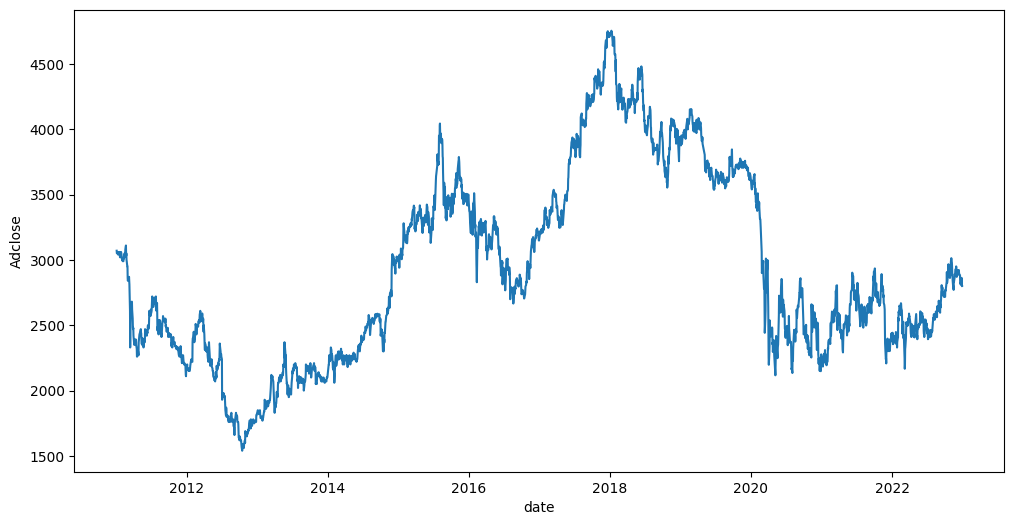

In [ ]:
# plt.title('Adjusted closing price Price History')
x = df_ana['Date']
y = df_ana["AdClose"]
plt.figure(figsize=(12,6))
plt.plot(x, y)
plt.xlabel('date')
plt.ylabel('Adclose')
plt.show()

In [ ]:
target_ana = df_ana['AdClose']
target_ana = np.array(target_ana).reshape(-1,1)
print(len(target_ana))

from sklearn .preprocessing import StandardScaler
# 正規化
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled_target_ana = scaler.fit_transform(np.array(target_ana).reshape(-1,1))
# データ分割
scaled_target_ana

2935


array([[ 0.20466913],
       [ 0.17720436],
       [ 0.17720436],
       ...,
       [-0.13040103],
       [-0.16816509],
       [-0.16610523]])

In [ ]:
# 予測期間
window_size = 20
predict_size=1
# train_rate=0.8

ana_x = []
ana_y = []

for i in range(len(scaled_target_ana)-window_size-predict_size):
  ana_x.append(scaled_target_ana[i:i+window_size,0])
  ana_y.append(scaled_target_ana[i+window_size:i+window_size+predict_size,0])

train_rate = sep / int(np.shape(ana_x)[0])

tr_x_ana = ana_x[:int(np.shape(ana_x)[0]*train_rate)]
te_x_ana = ana_x[int(np.shape(ana_x)[0]*train_rate):]
tr_y_ana = ana_y[:int(np.shape(ana_y)[0]*train_rate)]
te_y_ana = ana_y[int(np.shape(ana_y)[0]*train_rate):]

print('tr_x_ana：',np.shape(tr_x_ana)[0])
print('te_x_ana：',np.shape(te_x_ana)[0])
print('tr_y_ana：',np.shape(tr_y_ana)[0])
print('te_y_ana：',np.shape(te_y_ana)[0])

tr_x_ana： 2446
te_x_ana： 468
tr_y_ana： 2446
te_y_ana： 468


In [ ]:
# # numpy arrayに変換
tr_x_ana, tr_y_ana = np.array(tr_x_ana), np.array(tr_y_ana)
tr_x_ana = np.reshape(tr_x_ana, (tr_x_ana.shape[0], tr_x_ana.shape[1], 1))

te_x_ana = np.array(te_x_ana)
te_x_ana = np.reshape(te_x_ana, (te_x_ana.shape[0], te_x_ana.shape[1], 1))

In [ ]:
# モデル作成
def build_model(unit=60,dropout=0.2):
    model = Sequential()
    model.add(LSTM(unit,return_sequences = True, input_shape = (tr_x_ana.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(LSTM(unit,return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(unit,return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(unit))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))

    model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])

    return model

# グリッドサーチ

In [ ]:
# グリッドサーチによるハイパーパラメータ探索候補設定

# Define the grid search parameters
unit_grid = [30, 60, 90, 120]
dropout_grid = [0.1, 0.2, 0.3]
batch_size_grid = [16, 32, 64]

### the grid search parametersを辞書型で定義する
param_grids = dict(unit=unit_grid, dropout=dropout_grid, batch_size=batch_size_grid)

In [ ]:
# KerasRegressorでラッピング
# 乱数シードを固定値で初期化
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
model = KerasRegressor(build_model, unit=60, dropout=0.2, verbose=False)
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'unit', 'dropout'])

In [ ]:
# ハイパーパラメータチューニング(グリッドサーチのコンストラクタにモデルと辞書パラメータを指定)
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(estimator = model,        # モデル
                          param_grid = param_grids,  # チューニングするハイパーパラメータ
                          scoring = "neg_mean_squared_error",      # スコアリング
                          cv = 3
                         )

# 演算実行
gridsearch.fit(tr_x_ana, tr_y_ana)

GridSearchCV(cv=3,
             estimator=KerasRegressor(dropout=0.2, model=<function build_model at 0x7e9df5051f30>, unit=60, verbose=False),
             param_grid={'batch_size': [16, 32, 64], 'dropout': [0.1, 0.2, 0.3],
                         'unit': [30, 60, 90, 120]},
             scoring='neg_mean_squared_error')

In [ ]:
# グリッドサーチの結果から得られた最適なパラメータ候補を確認
print('Best params: {}'.format(gridsearch.best_params_))
print('Best Score: {}'.format(gridsearch.best_score_))

Best params: {'batch_size': 16, 'dropout': 0.2, 'unit': 90}
Best Score: -0.0529228370461467


# 学習・予測

In [ ]:
# 乱数シードを固定値で初期化
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
# lstm_ana = build_model(unit=gridsearch.best_params_['unit'], dropout=gridsearch.best_params_['dropout'])
# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# lstm_ana.fit(tr_x_ana, tr_y_ana, batch_size=gridsearch.best_params_['batch_size'], epochs=100, callbacks=[callback])

lstm_ana = build_model(unit=90, dropout=0.2)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=100)

lstm_ana.fit(tr_x_ana, tr_y_ana, batch_size=16, epochs=100, callbacks=[callback])

Epoch 1/100
153/153 [==============================] - 12s 12ms/step - loss: 0.0831 - accuracy: 0.0000e+00
Epoch 2/100
153/153 [==============================] - 2s 10ms/step - loss: 0.0360 - accuracy: 0.0000e+00
Epoch 3/100
153/153 [==============================] - 2s 10ms/step - loss: 0.0326 - accuracy: 0.0000e+00
Epoch 4/100
153/153 [==============================] - 2s 10ms/step - loss: 0.0271 - accuracy: 0.0000e+00
Epoch 5/100
153/153 [==============================] - 2s 10ms/step - loss: 0.0252 - accuracy: 0.0000e+00
Epoch 6/100
153/153 [==============================] - 2s 13ms/step - loss: 0.0226 - accuracy: 0.0000e+00
Epoch 7/100
153/153 [==============================] - 2s 13ms/step - loss: 0.0199 - accuracy: 0.0000e+00
Epoch 8/100
153/153 [==============================] - 2s 14ms/step - loss: 0.0206 - accuracy: 0.0000e+00
Epoch 9/100
153/153 [==============================] - 2s 13ms/step - loss: 0.0198 - accuracy: 0.0000e+00
Epoch 10/100
153/153 [=======================

In [ ]:
lstm_ana.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 90)            33120     
                                                                 
 dropout (Dropout)           (None, 20, 90)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 90)            65160     
                                                                 
 dropout_1 (Dropout)         (None, 20, 90)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 90)            65160     
                                                                 
 dropout_2 (Dropout)         (None, 20, 90)            0         
                                                                 
 lstm_3 (LSTM)               (None, 90)                6

In [ ]:
predictions = lstm_ana.predict(te_x_ana)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

te_y_ana = np.array(te_y_ana)
te_y_ana = scaler.inverse_transform(te_y_ana.reshape(-1,1))

15/15 [==============================] - 1s 5ms/step


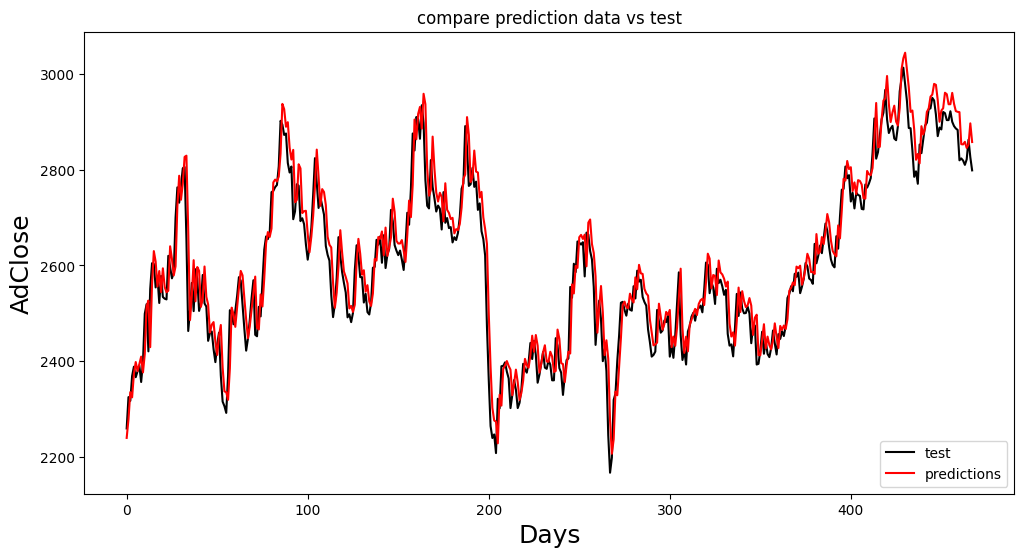

In [ ]:
plt.figure(figsize=(12,6))
plt.title('compare prediction data vs test')
plt.plot(te_y_ana,color='black')
plt.plot(predictions,color='red')
# plt.plot('Close')
plt.xlabel('Days', fontsize=18)
plt.ylabel('AdClose', fontsize=18)
plt.legend(['test', 'predictions'], loc = 'lower right')
plt.show()

In [ ]:
from sklearn.metrics import r2_score            # 決定係数
from sklearn.metrics import mean_squared_error  # RMSE
from sklearn.metrics import mean_absolute_percentage_error # MAPE
# mean_squared_error(test_y, pred, squared=False)


# 平均平方二乗誤差(RMSE)
print('RMSE テスト: %.5f' % (
        # mean_squared_error(y_train, y_train_pred, squared=False), # 学習
        mean_squared_error(te_y_ana, predictions, squared=False)    # テスト
      ))
print('r2_score_rakuten(Closeのみ) テスト: %.5f' % (
        # mean_squared_error(y_train, y_train_pred, squared=False), # 学習
        r2_score(te_y_ana, predictions)    # テスト
      ))

print('MAPE_rakuten(Closeのみ) テスト: %.5f' % (
        # mean_squared_error(y_train, y_train_pred, squared=False), # 学習
        mean_absolute_percentage_error(te_y_ana, predictions)    # テスト
      ))

RMSE テスト: 51.96624
r2_score_rakuten(Closeのみ) テスト: 0.91078
MAPE_rakuten(Closeのみ) テスト: 0.01574


# 予測データ　出力

In [ ]:
pred_lstm = df_ana_test.drop(columns=['Open','High','Low','Close','Turnover'])
pred_lstm

,Date,AdClose
2446,2021-01-04,2232.0
2447,2021-01-05,2204.5
2448,2021-01-06,2199.0
2449,2021-01-07,2191.5
2450,2021-01-08,2184.0
...,...,...
2930,2022-12-26,2821.5
2931,2022-12-27,2862.5
2932,2022-12-28,2826.0
2933,2022-12-29,2798.5


In [ ]:
pred_lstm.index[1]
pred_lstm_dummy = pred_lstm

pred_lstm = pred_lstm.drop(range(2446,2467))
pred_lstm

,Date,AdClose
2467,2021-02-03,2325.0
2468,2021-02-04,2317.0
2469,2021-02-05,2369.0
2470,2021-02-08,2388.5
2471,2021-02-09,2366.5
...,...,...
2930,2022-12-26,2821.5
2931,2022-12-27,2862.5
2932,2022-12-28,2826.0
2933,2022-12-29,2798.5


In [ ]:
pred_lstm['pred_lstm'] = predictions
pred_lstm

,Date,AdClose,pred_lstm
2467,2021-02-03,2325.0,2239.705078
2468,2021-02-04,2317.0,2278.507324
2469,2021-02-05,2369.0,2335.340332
2470,2021-02-08,2388.5,2324.329346
2471,2021-02-09,2366.5,2373.679688
...,...,...,...
2930,2022-12-26,2821.5,2858.130859
2931,2022-12-27,2862.5,2845.332764
2932,2022-12-28,2826.0,2852.329102
2933,2022-12-29,2798.5,2896.699463


In [ ]:
pred_lstm.to_csv('/content/content.drive/MyDrive/Colab Notebooks/csv/ANA/20/lstm_ana20_20112022.csv')